# Caso práctico

El objetivo de este documento es recordar y consolidar los aprendido durante la formación de Jupyter.

Las librerías y funciones se pueden cargar cuando se considere oportuno, aunque se recomienda hacerlo en cada apartado para tener claro qué se usa en cada caso.


## 1. Lectura de datos en S3 usando boto 3

Leer el fichero que se encuentra en **s3a://cityos/svc_cloudera/ingestion/cadastre/locals/barcino_u.sap_locals/locals.parquet** y convertir a pandas dataframe

In [1]:
def read_data_from_s3(bucket_name:str,
                      key_file_path:str,
                      file_path:str,
                      config_file_path:str, 
                      connection_name:str,
                      parameter_name='password'):
    
    # Leer el fichero de configuración
    config = configparser.ConfigParser()
    config_file_path = config_file_path
    config.read(config_file_path)  # Adjust the path to your config file

    # Almacenar información de la conexión
    connection_name = 'ceph_s3'
    connection_config = config[connection_name]
    s3_endpoint_url = connection_config['url']
    aws_access_key = connection_config['aws_access_key']
    aws_secret_key = connection_config['aws_secret_key'] # Contraseña encriptada

    # Desncriptar contraseña
    decrypted_password = decrypt_password_with_key(
        key_file_path='my_global_key.key',
        config_file_path=config_file_path,
        connection_name=connection_name,
        parameter_name=parameter_name
    )

   # Crear cliente de S3
    s3_client = boto3.client(
            "s3",
            "us-east-1",
            aws_access_key_id= aws_access_key,
            aws_secret_access_key= decrypted_password,
            endpoint_url= s3_endpoint_url,
            use_ssl= False,
            verify= False
    )

    print("read", file_path)
    
    # Lee el archivo Parquet desde S3
    s3_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)
    
    raw_data = io.BytesIO(s3_object['Body'].read())
    return raw_data

def decrypt_password_with_key(key_file_path:str, 
                              config_file_path:str, 
                              connection_name:str,
                              parameter_name="password"):
    # Cargar el ficheo con la clave
    with open(key_file_path, 'rb') as key_file:
        key = key_file.read()

    # Crear un cifrado Fernet con la clave
    cipher_suite = Fernet(key)
    
    # Leer la contraseña encriptada del fichero de configuración
    config = configparser.ConfigParser()
    config.read(config_file_path)  # Cargar el ficer de configuración
    
    encrypted_password = config.get(connection_name, parameter_name).encode()

    # Desencriptar contraseña
    decrypted_password = cipher_suite.decrypt(encrypted_password).decode()  # Convertir a string
    return decrypted_password

In [2]:
import configparser # Parsear el fichero de configuración
import boto3
from cryptography.fernet import Fernet # generar Fernet key
import io
import pyarrow.parquet as pq

In [3]:

bucket_name = 'cityos'
file_name = 'svc_cloudera/ingestion/cadastre/locals/barcino_u.sap_locals/locals.parquet'

data = read_data_from_s3 (bucket_name=bucket_name,
                    file_path=file_name,
                    key_file_path='my_global_key.key',
                    config_file_path='config.ini',
                    connection_name='ceph_s3',
                    parameter_name='aws_secret_key')
    
# Lee el contenido del objeto S3 y conviértelo en un DataFrame de pandas
parquet_file = pq.ParquetFile(data)
data_df = parquet_file.read().to_pandas()

data_df

read svc_cloudera/ingestion/cadastre/locals/barcino_u.sap_locals/locals.parquet


,SOLAR,NCARREC,NLOCAL,EPP,UNITAT_CONS,SUPERFICIE,DESTI,US,UCM,CATEGORIA,...,EPP_DGC,TIPUS_VALOR,SUP_TERRASSA,LOCAL_INTERIOR,ANY_CONSTRUCCIO,CODI_CARRER_GPL,NUM_I_GPL,NUM_F_GPL,NOM_CARRER_GPL,key
0,000792,0001,0001,PBJ,0001,530,YCB,Y,0832,3,...,P,E,0,N,1965.0000000000,106806,0024,0028,Duran i Borrell,1
1,000792,0001,0002,PBJ,0001,554,YCB,Y,0832,3,...,P,E,0,N,1965.0000000000,106806,0024,0028,Duran i Borrell,2
2,000792,0001,0003,P01,0001,554,YCB,Y,0832,3,...,P,E,0,N,1965.0000000000,106806,0024,0028,Duran i Borrell,3
3,000792,0001,0004,P02,0001,529,YCB,Y,0832,3,...,P,E,0,N,1965.0000000000,106806,0024,0028,Duran i Borrell,4
4,000792,0001,0005,P03,0001,387,YCB,Y,0832,3,...,P,E,0,N,1965.0000000000,106806,0024,0028,Duran i Borrell,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452686,584937,0000,0001,PBJ,0001,199,M,M,0000,0,...,P0,1,0,N,2022.0000000000,300106,0034,0036,Sant Frederic,1452687
1452687,584937,0000,0002,PAL,0001,160,M,M,0000,0,...,PL,1,0,N,2022.0000000000,300106,0034,0036,Sant Frederic,1452688
1452688,584937,0000,0003,P01,0001,199,M,M,0000,0,...,P1,1,0,N,2022.0000000000,300106,0034,0036,Sant Frederic,1452689
1452689,584937,0000,0004,P02,0001,199,M,M,0000,0,...,P2,1,0,N,2022.0000000000,300106,0034,0036,Sant Frederic,1452690


# Estudio previo y limpieza

## 2. Análisis previo del dataframe

Imprimir número de filas y columnas, tipos de campos, etc.

In [4]:
# Summary del dataframee
data_df.describe()

,key
count,1.452691e+06
mean,7.263460e+05
std,4.193559e+05
min,1.000000e+00
25%,3.631735e+05
50%,7.263460e+05
75%,1.089518e+06
max,1.452691e+06


In [5]:
print("info", data_df.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452691 entries, 0 to 1452690
Columns: 23 entries, SOLAR to key
dtypes: int64(1), object(22)
memory usage: 254.9+ MB
info None


## 3. Eliminar columnas

Eliminar las columnas **['SUP_TERRASSA', 'EPP_DGC']** del dataframe. Leer https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html para más información.

Imprime el nombre de las columnas existentes para verificar que se ha aplicado el cambio.

In [6]:
data_df = data_df.drop(columns=['SUP_TERRASSA', 'EPP_DGC'])
data_df.columns

Index(['SOLAR', 'NCARREC', 'NLOCAL', 'EPP', 'UNITAT_CONS', 'SUPERFICIE',
       'DESTI', 'US', 'UCM', 'CATEGORIA', 'ANY_REFORMA', 'TIPUS_REFORMA',
       'GPL', 'TIPUS_VALOR', 'LOCAL_INTERIOR', 'ANY_CONSTRUCCIO',
       'CODI_CARRER_GPL', 'NUM_I_GPL', 'NUM_F_GPL', 'NOM_CARRER_GPL', 'key'],
      dtype='object')

## 4. Renombrar columnas

Renombrar las columnas **['NLOCAL', 'NCARREC']** por **['N_LOCAL', 'N_CARREC']**. Revisar https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html para más información.

Imprime el nombre de las columnas existentes para verificar que se ha aplicado el cambio

In [7]:
data_df = data_df.rename(columns={"NLOCAL": "N_LOCAL", "NCARREC": "N_CARREC"})
data_df.columns

Index(['SOLAR', 'N_CARREC', 'N_LOCAL', 'EPP', 'UNITAT_CONS', 'SUPERFICIE',
       'DESTI', 'US', 'UCM', 'CATEGORIA', 'ANY_REFORMA', 'TIPUS_REFORMA',
       'GPL', 'TIPUS_VALOR', 'LOCAL_INTERIOR', 'ANY_CONSTRUCCIO',
       'CODI_CARRER_GPL', 'NUM_I_GPL', 'NUM_F_GPL', 'NOM_CARRER_GPL', 'key'],
      dtype='object')

## 5. Normalización

Sustituir los valores **['N', 'S']** de la variable 'LOCAL_INTERIOR' por **[False, True]**.

Imprimir los valores únicos de la variable para verificar el cambio.

In [8]:
data_df['LOCAL_INTERIOR'].unique()

array(['N', 'S'], dtype=object)

In [9]:
# Crear un diccionario de mapeo para reemplazar los valores
mapeo = {'N': False, 'S': True}

# Aplicar el reemplazo a la columna "sexo"
data_df['LOCAL_INTERIOR'] = data_df['LOCAL_INTERIOR'].replace(mapeo)

# Verificar el cambio
data_df['LOCAL_INTERIOR'].unique()

array([False,  True])

## 6. Gráficas exploratorias

Realizar gráficas exploratorias de los datos. Como mínimo un **gráfico circular de la variable 'TIPUS_VALOR'** y un **diagrama de barras de la variable 'CATEGORIA'**, puedes usar la función bar() de pyplot https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html

In [10]:
import matplotlib.pyplot as plt # Libería de visualización de datos

In [11]:
local_interior_counts = data_df['TIPUS_VALOR'].value_counts()
local_interior_counts

1    831737
7    442665
0    105914
4     33247
E     16889
6      9774
5      8241
9       270
V        33
Name: TIPUS_VALOR, dtype: int64

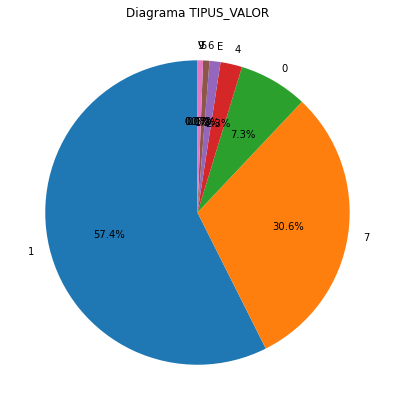

In [12]:
# Establecer el tamaño de la figura
plt.figure(figsize=(15, 7))

# Crear diagrama circular
tipus_valor_counts = data_df['TIPUS_VALOR'].value_counts()
plt.pie(tipus_valor_counts, labels=tipus_valor_counts.index, autopct='%1.1f%%', startangle=90)

# Personalizar la gráfica, añadiendo etiquetas y título
plt.title('Diagrama TIPUS_VALOR')

# Imprimir el histograma
plt.show()

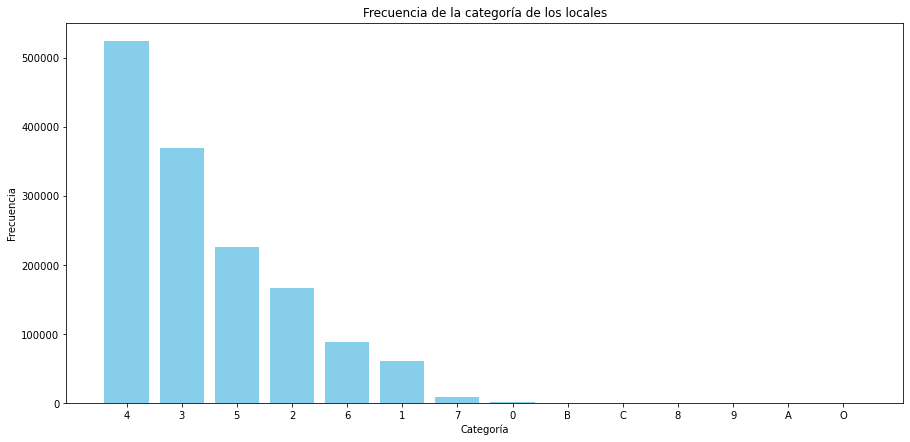

In [13]:
# Establecer el tamaño de la figura
plt.figure(figsize=(15, 7))

value_counts = data_df['CATEGORIA'].value_counts()

# Crear historgrama
plt.bar(value_counts.index, value_counts.values, color='skyblue')

# Personalizar la gráfica, añadiendo etiquetas y título
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de la categoría de los locales')

# Imprimir el histograma
plt.show()

## 7. Lectura de Trino

Lee la tabla **hive.staging.territori_segimon3_hdfs** usando Trino.

Imprime las primeras filas del dataframe para validar el resultado.

In [14]:
%%capture
!pip install trino

In [15]:
from trino.dbapi import trino
from trino.dbapi import connect
from trino.auth import BasicAuthentication

import pandas as pd

import warnings

# Deshabilitar warnings para que no aparezcan al confiar en el certificado
warnings.filterwarnings('ignore')

In [16]:
def run_trino_query(query, 
                    catalog,
                    key_file_path:str,
                    config_file_path:str, 
                    connection_name:str,
                    parameter_name='password'):
    # Leer el fichero de configuración
    config = configparser.ConfigParser()
    config_file_path = config_file_path
    config.read(config_file_path)  # Adjust the path to your config file

    # Almacenar información de la conexión
    connection_config = config[connection_name]
    trino_host = connection_config['host']
    trino_port = connection_config['port']
    trino_user = connection_config['user']
    trino_password = connection_config['password'] # Contraseña encriptada

    # Desncriptar contraseña
    decrypted_password = decrypt_password_with_key(
        key_file_path=key_file_path,
        config_file_path=config_file_path,
        connection_name=connection_name,
        parameter_name=parameter_name
    )
    
    conn = connect(host=trino_host,
                port=trino_port,
                user=trino_user,
                auth=BasicAuthentication(trino_user, decrypted_password),
                http_scheme='https',
                verify=False,
                catalog=catalog
    )

    cursor = conn.cursor()
    cursor.execute(query)
    result = cursor.fetchall()
    
    colnames = [desc[0] for desc in cursor.description]
    result_df = pd.DataFrame(result, columns=colnames)

    return result_df


In [17]:
segimon_table = run_trino_query(
    query='select * from hive.staging.territori_segimon3_hdfs',
    catalog='hive',
    key_file_path='my_global_key.key',
    config_file_path='config.ini',
    connection_name='trino_db',
    parameter_name='password'
    
)
segimon_table.head()

,codi_carr,numpost_i,llepost_i,numpost_f,llepost_f,tipusnum,districte,codi_illa,codi_parc,solar,...,md_ingesta_hdfs_time,md_data_structured,md_import_mode,md_src_entity,md_src_system,md_src_time,md_data_quality,md_security_level,md_lopd,md_priority
0,220404,0063,,0063,,1,07,27481,004,158355,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
1,220404,0043,,0043,,1,07,27481,011,152574,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
2,220404,0045,,0045,,1,07,27481,011,152574,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
3,220404,0065,,0065,,1,07,27481,003,080940,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
4,283200,0044,,0044,,2,10,90130,022,134586,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana


# Ejecicios avanzados

## 8. Join de dataframes

Hacer un left_join de la tabla de **segimon** con los datos de **locals** por el campo solar. Revisa la funión padas.merge() https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html.

Otras funciones interesantes en https://pandas.pydata.org/docs/user_guide/merging.html

In [18]:
merged_df = pd.merge(data_df, segimon_table, left_on='SOLAR', right_on='solar', how='left')
merged_df

,SOLAR,N_CARREC,N_LOCAL,EPP,UNITAT_CONS,SUPERFICIE,DESTI,US,UCM,CATEGORIA,...,md_ingesta_hdfs_time,md_data_structured,md_import_mode,md_src_entity,md_src_system,md_src_time,md_data_quality,md_security_level,md_lopd,md_priority
0,000792,0001,0001,PBJ,0001,530,YCB,Y,0832,3,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
1,000792,0001,0001,PBJ,0001,530,YCB,Y,0832,3,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
2,000792,0001,0001,PBJ,0001,530,YCB,Y,0832,3,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
3,000792,0001,0001,PBJ,0001,530,YCB,Y,0832,3,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
4,000792,0001,0001,PBJ,0001,530,YCB,Y,0832,3,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7317334,584937,0000,0001,PBJ,0001,199,M,M,0000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7317335,584937,0000,0002,PAL,0001,160,M,M,0000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7317336,584937,0000,0003,P01,0001,199,M,M,0000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7317337,584937,0000,0004,P02,0001,199,M,M,0000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
merged_df.columns

Index(['SOLAR', 'N_CARREC', 'N_LOCAL', 'EPP', 'UNITAT_CONS', 'SUPERFICIE',
       'DESTI', 'US', 'UCM', 'CATEGORIA', 'ANY_REFORMA', 'TIPUS_REFORMA',
       'GPL', 'TIPUS_VALOR', 'LOCAL_INTERIOR', 'ANY_CONSTRUCCIO',
       'CODI_CARRER_GPL', 'NUM_I_GPL', 'NUM_F_GPL', 'NOM_CARRER_GPL', 'key_x',
       'codi_carr', 'numpost_i', 'llepost_i', 'numpost_f', 'llepost_f',
       'tipusnum', 'districte', 'codi_illa', 'codi_parc', 'solar', 'xnum_post',
       'ynum_post', 'angle', 'dist_post', 'secc_cens', 'secc_est', 'barri',
       'gpl', 'principal', 'principalgpl', 'codi_geoadreca', 'estat_carto',
       'etiqueta', 'geometria', 'zeg', 'zrp', 'data_canvi', 'md_data_canvi',
       'nivell_error_geocod', 'x_etrs89', 'y_etrs89', 'longitud_wgs84',
       'latitud_wgs84', 'nom18', 'nom_ordenar', 'nom_oficial', 'desc_tipusnum',
       'x_ed50', 'y_ed50', 'numero_carrer', 'codi_ine', 'tipus_via',
       'desc_tipus_via', 'sequencia', 'desc_sequencia', 'aprovacio',
       'data_aprov', 'aeb', 'spo', 

## 9. Mapa

Te atreverías a en un mapa la localización de los 10 primero locales del dataframe generado en el apartado anterior. Puedes usar las variables **latitud_wgs84** y **longitud_wgs84**.

In [20]:
print(merged_df['latitud_wgs84'])
print(merged_df['longitud_wgs84'])

0          41.4186148
1          41.4185732
2          41.4186148
3          41.4186148
4          41.4185732
              ...    
7317334           NaN
7317335           NaN
7317336           NaN
7317337           NaN
7317338           NaN
Name: latitud_wgs84, Length: 7317339, dtype: object
0          2.1497593
1          2.1499018
2          2.1497593
3          2.1497593
4          2.1499018
             ...    
7317334          NaN
7317335          NaN
7317336          NaN
7317337          NaN
7317338          NaN
Name: longitud_wgs84, Length: 7317339, dtype: object


In [21]:
import random 
random_df = merged_df.sample(n=10, random_state=random.seed())
random_df

,SOLAR,N_CARREC,N_LOCAL,EPP,UNITAT_CONS,SUPERFICIE,DESTI,US,UCM,CATEGORIA,...,md_ingesta_hdfs_time,md_data_structured,md_import_mode,md_src_entity,md_src_system,md_src_time,md_data_quality,md_security_level,md_lopd,md_priority
3579092,553579,0447,0448,6PP13,0001,21,AAP,A,0222,4,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
3545722,552871,0020,0021,P0208,0001,37,V,V,0111,6,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
1532347,153369,0029,0042,2P0103,0001,95,V,V,0112,3,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
3562081,553387,0001,0077,P0301,0001,352,YCL,Y,0812,2,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
2130283,206950,0001,0005,PBJ04,0001,36,V,V,0111,6,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
4949152,574821,0040,0041,1PP40,0001,9,AAP,A,0113,4,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
4429960,573928,0063,0064,PBJ3C,0001,127,C,C,0411,4,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
836250,125433,0018,0019,PBJ18,0001,26,AAP,A,0113,4,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
5934227,578162,0283,0367,1PP307,0001,11,AAP,A,0113,3,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana
2652762,303588,0072,0073,BP0703,0001,82,V,V,0112,6,...,1687856668021,structured,batch,segimon3,territori,1687856721755,high,normal,no,mitjana


In [22]:
reduced_df = random_df[['latitud_wgs84', 'longitud_wgs84']]
reduced_df

,latitud_wgs84,longitud_wgs84
3579092,41.3817988,2.1731393
3545722,41.4446679,2.1726962
1532347,41.3849315,2.1390403
3562081,41.4150566,2.1758015
2130283,41.3787972,2.1891321
4949152,41.4357728,2.1678908
4429960,41.4117921,2.1885673
836250,41.4340943,2.1890762
5934227,41.4058617,2.2098122
2652762,41.4247686,2.2020288


In [23]:
reduced_df['longitud_wgs84'] = pd.to_numeric(reduced_df['longitud_wgs84'])
reduced_df['latitud_wgs84'] = pd.to_numeric(reduced_df['latitud_wgs84'])
reduced_df

,latitud_wgs84,longitud_wgs84
3579092,41.381799,2.173139
3545722,41.444668,2.172696
1532347,41.384932,2.139040
3562081,41.415057,2.175801
2130283,41.378797,2.189132
4949152,41.435773,2.167891
4429960,41.411792,2.188567
836250,41.434094,2.189076
5934227,41.405862,2.209812
2652762,41.424769,2.202029


In [24]:
%%capture
!pip install folium

In [25]:
import folium

mapa = folium.Map(location=[reduced_df['latitud_wgs84'].mean(), reduced_df['latitud_wgs84'].mean()], zoom_start=11)

for index, row in reduced_df.iterrows():
    folium.Marker(
        location=[row['latitud_wgs84'], row['longitud_wgs84']],
    ).add_to(mapa)
    
mapa

# Fin de la práctica

Si has llegado hasta aquí significa que ya manejas muy bien Python!! Ahora puedes descargar el notebook y presumir de tus resultados :)

<img src="https://cdn-icons-png.flaticon.com/512/5625/5625810.png" alt="Alt text" width="100">
